# 2) Downloading ERA5 data

Importing the necessary lybraries:


cfgrib is installed as:
conda install -c conda-forge cfgrib
xarray is installed as:
conda install -c conda-forge xarray dask netCDF4 bottleneck

In [1]:
import warnings
warnings.filterwarnings("ignore")
import sys;sys.path.append('../adcirc_swan')
import adcirc as adc;import regional as reg
from arctic import *
import sys,getopt
import pandas as pd;import numpy as np
import pathlib as pl
import numpy.core.multiarray 
import netCDF4 as nc4;import xarray as xr
import scipy.interpolate
import datetime;import json
from pyproj import Proj, transform,Transformer
import matplotlib.pyplot as plt;
import matplotlib as mpl;
import cartopy as cart
import cartopy.crs as ccrs
import wrf
from wrf import PolarStereographic
from pyproj.crs import BoundCRS, Ellipsoid, GeographicCRS, ProjectedCRS
import geopandas as gpd;import shapely as shape
import boto3; import os
import sys; from shapely import Polygon, Point, MultiPoint, LineString

Paste the API request and start downloading:

In [2]:
from numpy import interp

class Progress:
    def __init__(self, value, end, title='Downloading',buffer=20):
        self.title = title
        #when calling in a for loop it doesn't include the last number
        self.end = end -1
        self.buffer = buffer
        self.value = value
        self.progress()

    def progress(self):
        maped = int(interp(self.value, [0, self.end], [0, self.buffer]))
        print(f'{self.title}: [{"#"*maped}{"-"*(self.buffer - maped)}]{self.value}/{self.end} {((self.value/self.end)*100):.2f}%', end='\r')

In [3]:
def compute_grid(wrf_proj, geo_ds):
    wgs_proj = Proj(proj='latlong', datum='WGS84')
    transformer = Transformer.from_proj(wgs_proj, wrf_proj)

    # Easting and Northings of the domains center point
    e, n = transformer.transform(geo_ds.CEN_LON, geo_ds.CEN_LAT)
    # Grid parameters
    dx, dy = geo_ds.DX, geo_ds.DY
    nx, ny = geo_ds.dims['west_east'], geo_ds.dims['south_north']
    # Down left corner of the domain
    x0 = -(nx-1) / 2. * dx + e
    y0 = -(ny-1) / 2. * dy + n
    # 2d grid
    xx, yy = np.meshgrid(np.arange(nx) * dx + x0, np.arange(ny) * dy + y0)
    
    return xx, yy

In [4]:
def compute_error(wrf_proj, xx, yy):
    wgs_proj = Proj(proj='latlong', datum='WGS84')
    transformer = Transformer.from_proj(wrf_proj, wgs_proj)
    our_lons, our_lats = transformer.transform(xx, yy)
    error_arr = np.sqrt((our_lons - geo_ds.XLONG_M)**2 + (our_lats - geo_ds.XLAT_M)**2)
    
    return error_arr.values[0]

In [5]:
path = pl.Path('/Users/tmiesse/work/FHRL/arctic/climate_data/era_interim')
files = list((path / 'wind').glob('u*'))
files2= list((path / 'wind').glob('v*'))
#file = 'seaice_hourly_wrf_ERA-Interim_historical_1979.nc'

wrf_ds_u = xr.open_dataset(files[2])
wrf_ds_v = xr.open_dataset(files2[0])
geo_ds = xr.open_dataset(path / 'geo_em.d01.nc' )
geo_ds.attrs["MAP_PROJ"]

2

In [6]:
wrf_proj = Proj(
    proj="lcc", # projection type: Lambert Conformal Conic
    lat_1=geo_ds.TRUELAT1, lat_2=geo_ds.TRUELAT2, # Cone intersects with the sphere
    lat_0=geo_ds.MOAD_CEN_LAT, lon_0=geo_ds.STAND_LON, # Center point
    a=6370000, b=6370000 # This is it! The Earth is a perfect sphere
) 
# WGS 
wgs_proj = Proj(proj='latlong', datum='WGS84')

In [7]:
xx, yy = compute_grid(wrf_proj, geo_ds)

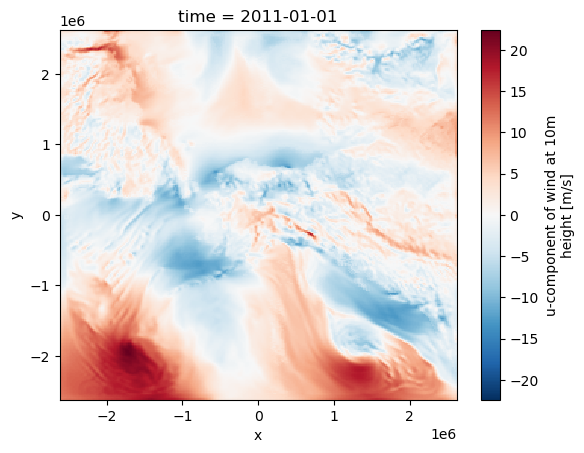

In [9]:
new_ds = wrf_ds_u.rename_dims({"yc": "y", "xc": "x"})
new_ds = new_ds.assign_coords({"y": ("y", yy[::-1,0]), "x": ("x", xx[0,:])})
new_ds2 = wrf_ds_v.rename_dims({"yc": "y", "xc": "x"})
new_ds2 = new_ds2.assign_coords({"y": ("y", yy[::-1,0]), "x": ("x", xx[0,:])})
new_ds.u10[0].plot()

In [10]:
wrf_vars = ["TRUELAT1", "TRUELAT2", "MOAD_CEN_LAT", "STAND_LON", "POLE_LAT", "POLE_LON"]
wrf_proj_str = PolarStereographic(**{var: geo_ds.attrs[var] for var in wrf_vars}).proj4()
wrf_proj = Proj(wrf_proj_str)
xx, yy = compute_grid(wrf_proj, geo_ds)
error_arr = compute_error(wrf_proj, xx, yy)


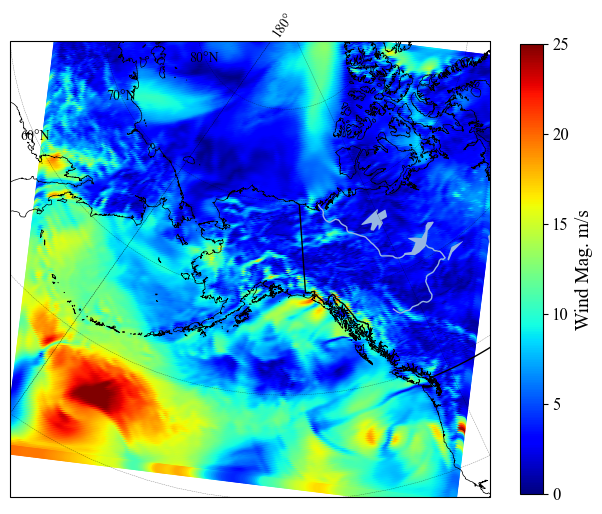

In [11]:
inProj = Proj(wrf_proj_str)
outProj = Proj(init='epsg:4326')
x2,y2 = transform(inProj,outProj,xx,yy[::-1])
dt=300
data = np.sqrt(np.square(wrf_ds_u['u10'][dt,:,:])+np.square(wrf_ds_v['v10'][dt,:,:]))

# map boundary ------------------------------------------------------------------------
lat1,lat2 = 40,87
lon1,lon2 = -180,-120

# -------------------------------------------------------------------------------------
plt.rcParams["font.family"] = "Times New Roman"
cmap = mpl.cm.get_cmap('cool')

fig = plt.figure(figsize=(6,5))
proj = ccrs.NorthPolarStereo(central_longitude=-145)
#tiler = cart_img.GoogleTiles('terrain-background')

ax = plt.axes([0,0,1.,1.],projection=proj)
cmap = mpl.cm.get_cmap('jet')
fig.tight_layout(pad=0.75)
levels = np.arange(np.min(data),np.max(data),1000)

xre = np.reshape(x2,x2.shape[0]*x2.shape[1])
yre = np.reshape(y2,y2.shape[0]*y2.shape[1])
data2 = np.reshape(data.data,x2.shape[0]*x2.shape[1])
# Initialize data for map
ax.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax.coastlines(resolution='10m',linewidth=0.5)
ax.add_feature(cart.feature.LAKES)
ax.add_feature(cart.feature.RIVERS, linestyle="-")
ax.add_feature(cart.feature.BORDERS.with_scale("50m"), linestyle="-")
normalize = mpl.colors.Normalize(vmin=0, vmax=25)
cmap = mpl.cm.get_cmap('jet')
data2[data2<=0.001]=np.nan
colors = [cmap(normalize(d)) for d in data2]
ax.scatter(xre,yre,c=colors,cmap=cmap,transform = ccrs.PlateCarree())
cax, _ = mpl.colorbar.make_axes(ax,shrink=.9)
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=normalize)
cbar.set_label(r'Wind Mag. m/s',fontsize=14)
cbar.ax.tick_params(labelsize=12)
#ax.set_title('',fontsize=12)
gl = ax.gridlines(draw_labels=True, linewidth=0.3, color="black", alpha=0.5, linestyle="--")
# subplot adjustment -----------------------------------------------------------

plt.savefig('/Users/tmiesse/work/FHRL/arctic/climate_data/era_interim/figures/wind1979.png',dpi=480,bbox_inches = 'tight', pad_inches = 0.1)
plt.show(fig)

In [12]:
inProj = Proj(wrf_proj_str)
outProj = Proj(init='epsg:4326')
x2,y2 = transform(inProj,outProj,xx,yy[::-1])
x3 = np.zeros(x2.shape)
for i in range(0,x2.shape[0]):
    for j in range(0,x2.shape[1]):
        if x2[i,j]>0:
            x3[i,j] = x2[i,j]-360
        else:
            x3[i,j] = x2[i,j]

In [5]:
def force2owibasin(file:str,dx:float,dy:float,dt:np.array,ilon:int,ilat:int,\
                start:datetime,end:datetime,swlat:int,swlon:int,header:str,\
                lat1:float,lat2:float,lon1:float,lon2:float,lat=None,lon=None,data=None,\
                u=None,v=None,interval:int=1):


    with open(file,'w') as fin:
        fin.write(header)
        for t in np.arange(0,len(dt),interval):
            param ='iLat={:4d}iLong={:4d}DX={:6.4f}DY={:6.4f}SWLat={:8.5f}SWLon={:8.3f}DT={:12s}\n'.\
            format(ilat,ilon,dx,dy,swlat,swlon,str(dt[t].strftime('%Y%m%d%H%M')))#,width=8,prec=5)
            fin.write(param)
            data2 = []
            d1,d2 = [],[] 
            for y in range(0,lon.shape[0]):
                for x in range(0,lon.shape[1]):
                    if file == 'fort.224':
                        windx = u[t,y,x]
                        windy = v[t,y,x]
                        d1.append(' {:{width}.{prec}f}'.format(windx,width=9,prec=4))
                        d2.append(' {:{width}.{prec}f}'.format(windy,width=9,prec=4))
                    elif file == 'fort.223':
                        press = data[t,y,x]/100
                        data2.append(' {:{width}.{prec}f}'.format(press,width=9,prec=4))
                    elif file == 'fort.225':
                        sea = data[t,y,x]
                        if np.isnan(sea):
                            sea = -1.0
                        else:
                            sea =sea #* 100
                        data2.append(' {:{width}.{prec}f}'.format(sea,width=9,prec=4))
            i = 0
            if file == 'fort.224':
                for d in range(len(d1)):
                    if (i == 7) & (d+1!=len(d1)) :
                        fin.write(d1[d]+'\n')
                        i=0
                    elif d+1>=len(d1):
                        #print(d + 'made it here')
                        fin.write(d2[d]+'\n')
                        i = 0
                        for d in range(len(d2)):

                            if (i == 7) :
                                fin.write(d2[d]+'\n')
                                i=0
                            elif (d+1>=len(d2)):
                                fin.write(d2[d]+'\n')
                            else:
                                fin.write(d2[d])
                                i +=1
                    else:
                        fin.write(d1[d])
                        i +=1
            else:
                for d in range(len(data2)):
                    if (i == 7) : 
                        fin.write(data2[d]+'\n')
                        i=0
                    elif (d+1>=len(data2)):
                        fin.write(data2[d]+'\n')
                    else:
                        fin.write(data2[d])
                        i +=1

    return print('generated owi formatted forcings')

In [6]:
path = pl.Path('/Users/tmiesse/work/FHRL/arctic/model/ice_paper/storm2019/sea_ice/hycom')
files = list((path / 'data').glob('*'))


In [7]:
grib = xr.open_dataset(path / files[0])#, engine='cfgrib')
x,y = np.nan_to_num(grib['TLON'].data),np.nan_to_num(grib['TLAT'].data)

In [8]:
lat1,lat2 = 30,90
lon1,lon2 = -220, -84

In [ ]:
x,y = np.nan_to_num(grib['TLON'].data),np.nan_to_num(grib['TLAT'].data)
xgrid,ygrid = np.meshgrid(x,y)
inProj = Proj(init='epsg:3411')
outProj = Proj(init='epsg:4326')
x2,y2 = transform(inProj,outProj,xgrid,ygrid)

In [8]:
x

array([[334.      , 270.08002 , 270.16    , ...,  37.76001 ,  37.839996,
         37.920013],
       [334.      , 270.08002 , 270.16    , ...,  37.76001 ,  37.839996,
         37.920013],
       [334.      , 270.08002 , 270.16    , ...,  37.76001 ,  37.839996,
         37.920013],
       ...,
       [174.23999 , 238.16    , 238.07999 , ..., 110.47998 , 110.399994,
        110.32001 ],
       [174.23999 , 238.16    , 238.07999 , ..., 110.47998 , 110.399994,
        110.32001 ],
       [174.23999 , 238.16    , 238.07999 , ..., 110.47998 , 110.399994,
        110.32001 ]], dtype=float32)

In [12]:
x3 = np.zeros(x2.shape)
for i in range(0,x2.shape[0]):
    for j in range(0,x2.shape[1]):
        if x2[i,j]>0:
            x3[i,j] = x2[i,j]-360
        else:
            x3[i,j] = x2[i,j]

NameError: name 'x2' is not defined

In [13]:
x

NameError: name 'x' is not defined

In [12]:
daily = pd.date_range('20040101','20040125',freq='1D')

In [23]:
day = daily[3].strftime('%Y%m%d')

In [35]:
grib

<xarray.Dataset>
Dimensions:                         (tdim: 1, y: 448, x: 304)
Coordinates:
    time                            (tdim) datetime64[ns] ...
    xgrid                           (x) float32 ...
    ygrid                           (y) float32 ...
Dimensions without coordinates: tdim, y, x
Data variables:
    cdr_seaice_conc                 (tdim, y, x) float32 0.0 0.0 0.0 ... 0.0 0.0
    melt_onset_day_cdr_seaice_conc  (tdim, y, x) float32 ...
    nsidc_bt_seaice_conc            (tdim, y, x) float32 ...
    nsidc_nt_seaice_conc            (tdim, y, x) float32 ...
    projection                      |S1 ...
    qa_of_cdr_seaice_conc           (tdim, y, x) float32 ...
    spatial_interpolation_flag      (tdim, y, x) float32 ...
    stdev_of_cdr_seaice_conc        (tdim, y, x) float32 ...
    temporal_interpolation_flag     (tdim, y, x) float32 ...
Attributes: (12/40)
    Conventions:               CF-1.6, ACDD-1.3
    title:                     NOAA/NSIDC Climate Data Record of Passive Micr...
    references:                Comiso, J. C., and F. Nishio. 2008. Trends in ...
    comment:                   none
    program:                   NOAA Climate Data Record Program
    cdr_variable:              cdr_seaice_conc
    ...                        ...
    source:                    Generated from NSIDC0001
    platform:                  DMSP 5D-2/F13 > Defense Meteorological Satelli...
    sensor:                    SSM/I > Special Sensor Microwave/Imager
    date_created:              2021-06-21T18:06:28Z
    time_coverage_start:       2004-01-01T00:00:00Z
    time_coverage_end:         2004-01-01T23:59:59Z

In [62]:
x3.shape,y2.shape,sice.shape

((448, 304), (448, 304), (1, 448, 304))

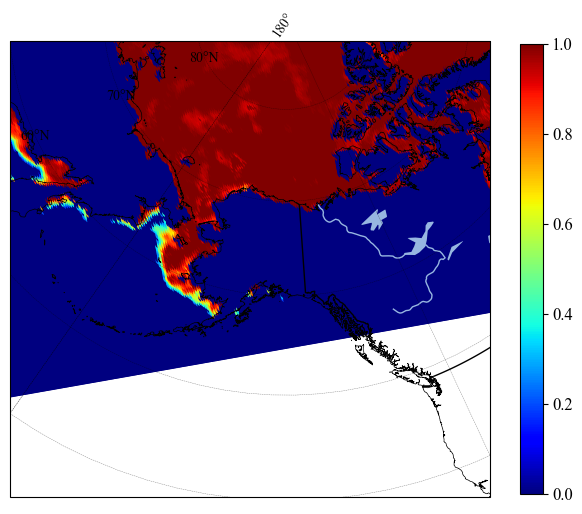

In [72]:
#inProj = Proj(wrf_proj_str)
#outProj = Proj(init='epsg:4326')
#x2,y2 = transform(inProj,outProj,xx,yy[::-1])
#dt=300


# map boundary ------------------------------------------------------------------------
lat1,lat2 = 40,87
lon1,lon2 = -180,-120

# -------------------------------------------------------------------------------------
plt.rcParams["font.family"] = "Times New Roman"
cmap = mpl.cm.get_cmap('cool')

fig = plt.figure(figsize=(6,5))
proj = ccrs.NorthPolarStereo(central_longitude=-145)
#tiler = cart_img.GoogleTiles('terrain-background')
sice[sice>1]=0
ax = plt.axes([0,0,1.,1.],projection=proj)
cmap = mpl.cm.get_cmap('jet')
fig.tight_layout(pad=0.75)
levels = np.arange(np.min(sice),np.max(sice),0.1)

# Initialize data for map
ax.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax.coastlines(resolution='10m',linewidth=0.5)
ax.add_feature(cart.feature.LAKES)
ax.add_feature(cart.feature.RIVERS, linestyle="-")
ax.add_feature(cart.feature.BORDERS.with_scale("50m"), linestyle="-")

cmap = mpl.cm.get_cmap('jet')

xre = np.reshape(x3,x3.shape[0]*x3.shape[1])
yre = np.reshape(y2,y2.shape[0]*y2.shape[1])
data2= np.reshape(sice[0,:,:],x2.shape[0]*x2.shape[1])

normalize = mpl.colors.Normalize(vmin=np.min(data2), vmax=np.max(data2))
colors = [cmap(normalize(d)) for d in data2]
ax.scatter(xre,yre,c=colors,cmap=cmap,transform = ccrs.PlateCarree())



cax, _ = mpl.colorbar.make_axes(ax,shrink=.9)
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=normalize)
#cbar.set_label(r'Wind Mag. m/s',fontsize=14)
cbar.ax.tick_params(labelsize=12)
#ax.set_title('',fontsize=12)
gl = ax.gridlines(draw_labels=True, linewidth=0.3, color="black", alpha=0.5, linestyle="--")
# subplot adjustment -----------------------------------------------------------

#plt.savefig('/Users/tmiesse/work/FHRL/arctic/climate_data/era_interim/figures/wind1979.png',dpi=480,bbox_inches = 'tight', pad_inches = 0.1)
plt.show(fig)

In [69]:
levels

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5])

In [11]:
xre = np.reshape(x3,x3.shape[0]*x3.shape[1])
yre = np.reshape(y2,y2.shape[0]*y2.shape[1])
lat1,lat2 = 40,90
lon1,lon2 = -240, -80
grid_space = 0.09
xg = np.arange(lon1,lon2,grid_space)
yg = np.arange(lat1,lat2,grid_space)
xgrid,ygrid = np.meshgrid(xg,yg)
sice2 = np.zeros((len(files),xgrid.shape[0],xgrid.shape[1]))
count = 0
for day in daily:
    file = [s for s in files if day.strftime('%Y-%m-%d-%H%M%s') in str(s)]
    grib = xr.open_dataset(path / file[0])
    sice = grib['aice'].data
    sice[sice>1]=0
    temp = np.reshape(sice[0,:,:],x2.shape[0]*x2.shape[1])
    data = scipy.interpolate.griddata((xre,yre),temp,(xgrid,ygrid),method='nearest')
    sice2[count,:,:] = data

    count+=1

NameError: name 'x3' is not defined

In [32]:
time = grib['time']
ts = [(t - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')  for t in time.data]
ts2 = [datetime.datetime.utcfromtimestamp(t) for t in ts]

In [36]:
time.data[-1]

numpy.datetime64('2004-01-01T00:00:00.000000000')

In [76]:
sice2.shape

(25, 250, 800)

In [81]:
#ts = [(t - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')  for t in time]
#ts2 = [datetime.datetime.utcfromtimestamp(t) for t in ts]
#ts2 = time
dx = 0.2#np.abs(lon[0]-lon[1])# 0.205 is cfsv2 wind increment
dy = 0.2#np.abs(lat[0]-lat[1])#
ilon = xgrid.shape[1]
ilat = xgrid.shape[0]
start = daily[0]
end = daily[-1]
swlat = lat1
swlon = lon1#+360
header = 'Oceanweather WIN/PRE Format                            {:12s}   {:12s}\n'.format(str(start.strftime('%Y%m%d%H')),str(end.strftime('%Y%m%d%H')))#     {}'
dt = daily
file = 'fort.225'

force2owibasin(file,dx,dy,dt,ilon,ilat,start,end,swlat,swlon,header,\
               lat1,lat2,lon1,lon2,lat=ygrid,lon=xgrid,data=sice2,)

generated owi formatted forcings


In [18]:
file = xr.open_dataset(files[9])
file2= xr.open_dataset(files2[2])
u = file['u10'][:]
v = file2['v10'][:]

In [19]:
time = file['time']
ts = [(t - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')  for t in time.data]
ts2 = [datetime.datetime.utcfromtimestamp(t) for t in ts]

In [23]:
ts2[478]

datetime.datetime(2004, 1, 20, 22, 0)

In [24]:
xre = np.reshape(x3,x3.shape[0]*x3.shape[1])
yre = np.reshape(y2,y2.shape[0]*y2.shape[1])


lat1,lat2 = 60,90
lon1,lon2 = -180, -140
grid_space = 0.2
xg = np.arange(lon1,lon2,grid_space)
yg = np.arange(lat1,lat2,grid_space)
xgrid,ygrid = np.meshgrid(xg,yg)
u2 = np.zeros((u.shape[0],xgrid.shape[0],xgrid.shape[1]))
v2 = np.zeros((v.shape[0],xgrid.shape[0],xgrid.shape[1]))
for p in range(0,478):
    temp = np.reshape(u.data[p,:,:],x2.shape[0]*x2.shape[1])
    data = scipy.interpolate.griddata((xre,yre),temp,(xgrid,ygrid),method='nearest')
    u2[p,:,:] = data
    temp2 = np.reshape(v.data[p,:,:],x2.shape[0]*x2.shape[1])
    data2 = scipy.interpolate.griddata((xre,yre),temp2,(xgrid,ygrid),method='nearest')
    v2[p,:,:] = data2

In [27]:
#ts = [(t - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')  for t in time]
#ts2 = [datetime.datetime.utcfromtimestamp(t) for t in ts]
#ts2 = time
dx = 0.2#np.abs(lon[0]-lon[1])# 0.205 is cfsv2 wind increment
dy = 0.2#np.abs(lat[0]-lat[1])#
ilon = xgrid.shape[1]
ilat = xgrid.shape[0]
start = ts2[0]
end = ts2[478]
swlat = lat1
swlon = lon1#+360
header = 'Oceanweather WIN/PRE Format                            {:12s}   {:12s}\n'.format(str(start.strftime('%Y%m%d%H')),str(end.strftime('%Y%m%d%H')))#     {}'
dt = ts2[:478]
file = 'fort.224'

force2owibasin(file,dx,dy,dt,ilon,ilat,start,end,swlat,swlon,header,\
               lat1,lat2,lon1,lon2,lat=ygrid,lon=xgrid,u=u2,v=v2,interval=2)

generated owi formatted forcings


In [6]:
from shapely.geometry import Point,Polygon,LineString

In [7]:
countries = gpd.read_file('/Users/tmiesse/work/FHRL/arctic/gis/ne_10m_ocean/ne_10m_ocean.shp')

In [15]:
xs = np.reshape(x2,x2.shape[0]*x2.shape[1])
ys = np.reshape(y2,y2.shape[0]*y2.shape[1])
pts = [Point(xs[i],ys[i]) for i in range(0,len(xs))]

In [16]:
ids = []
c = 0
for pt in pts:
    if countries.geometry.contains(pt)[0]:
        ids.append(c)
    c+=1

KeyboardInterrupt: 

In [15]:
time = wrf_ds['time'][:]
count = 0
track = []
year = []
month = []

step = 0.01
xmin,xmax = 0,0
ymin,ymax = 0,0
oldpt = []
shpfile = {'year':[],'month':[],'geometry':[]}
for t in np.arange(0,len(time[:120]),6):
    psfc = np.reshape(wrf_ds['psfc'][t,:,:].data,x2.shape[0]*x2.shape[1])
            
            
    idx = np.where((psfc[ids]==np.min(psfc[ids])))[0]
    
    xmin,xmax = xs[idx]-step,xs[idx]+step
    ymin,ymax = ys[idx]-step,ys[idx]+step
    
    bbox = Polygon([[xmin,ymin],[xmax,ymin],[xmax,ymax],[xmin,ymax]])
    npt = pts[idx]
    if (npt not in track) & (bbox.contains(npt)):
        track.append(npt)
    elif (pd.to_datetime(time.data[t]).year not in year):
        year.append(pd.to_datetime(time.data[t]).year)
    elif pd.to_datetime(time.data[t]).month_name() not in month:
        month.append(pd.to_datetime(time.data[t]).month_name())

    if t>24:
        if npt in oldpt:
            shpfile['year'].append(year)
            shpfile['month'].append(month)
            shpfile['geometry'].append(track)
            track = []
            year = []
            month = []

    Progress(count,len(time[:]),title='Computing')
    count+=6


KeyboardInterrupt: 

In [18]:
pd.to_datetime(file['Time'][1],format='%Y%m%d%H')

Timestamp('1989-01-30 12:00:00')

In [16]:
file['Time'][1]

1989013012.0

In [83]:
days = pd.to_datetime(file['Time'][idx[1]])-pd.to_datetime(file['Time'][idx[-1]])#pd.Timedelta(hours=48)

NameError: name 'idx' is not defined

In [10]:
file = pd.read_csv('/Users/tmiesse/work/FHRL/arctic/model/climate_data/track_data/Post_processed_cyclones_MIROC6_historical.csv')

In [13]:
file['Time']

0                        NaN
1        1985-01-01 12:00:00
2        1985-01-01 18:00:00
3        1985-01-02 00:00:00
4        1985-01-02 06:00:00
                ...         
46548    2014-12-28 00:00:00
46549    2014-12-28 06:00:00
46550    2014-12-28 12:00:00
46551    2014-12-28 18:00:00
46552    2014-12-29 00:00:00
Name: Time, Length: 46553, dtype: object

In [15]:
keys = file['Cyc_ID'].unique()
storm = {'track':[]}
step = 2
for k in range(0,len(keys)):
    idx = file.index[np.where(file['Cyc_ID']==keys[k])]
    tracks= {'id':[],'lat':[],'lon':[],'time':[]}
    count = 0
    for i in idx:
        if count<1:
            days = pd.to_datetime(file['Time'][idx[-1]],format='%Y-%m-%d %H:%M:%S')-pd.to_datetime(file['Time'][idx[1]],format='%Y-%m-%d %H:%M:%S')            
        if days.days>2:
            tracks['id'].append(file['Cyc_ID'][i])
            tracks['lat'].append(file['Lat'][i])
            if file['Lon'][i]>0:
                lons = file['Lon'][i]-360
            else:
                lons = file['Lon'][i]
            tracks['lon'].append(lons)
            tracks['time'].append(pd.to_datetime(file['Time'][i],format='%Y-%m-%d %H:%M:%S'))
        count+=1
    if len(tracks['id'])<2:
        pass
    else:
        storm['track'].append(tracks)

In [7]:
def noaa_data(begin,end,station,vdatum='NAVD',interval='6',
                       form='json',t_zone='GMT',unit='metric',product='water_level'):
    if product=='wind':
        api = f'https://api.tidesandcurrents.noaa.gov/api/prod/datagetter?begin_date={begin}&end_date={end}&station={station}'\
        f'&product={product}&time_zone={t_zone}&interval={interval}&units={unit}&application=DataAPI_Sample&format={form}'
    else:
        api = f'https://tidesandcurrents.noaa.gov/api/datagetter?begin_date={begin}&end_date={end}&station={station}'\
             f'&product={product}&application=NOS.COOPS.TAC.WL&datum={vdatum}&interval={interval}&time_zone={t_zone}&units={unit}&format={form}'
    data = requests.get(url=api).content.decode()
    return data


In [22]:
interval='h'
station=9497645
start = '20040101'
end   = '20040201'
noaa = json.loads(noaa_data(start,end,int(station),interval=interval,t_zone='LST',vdatum='MSL'))

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

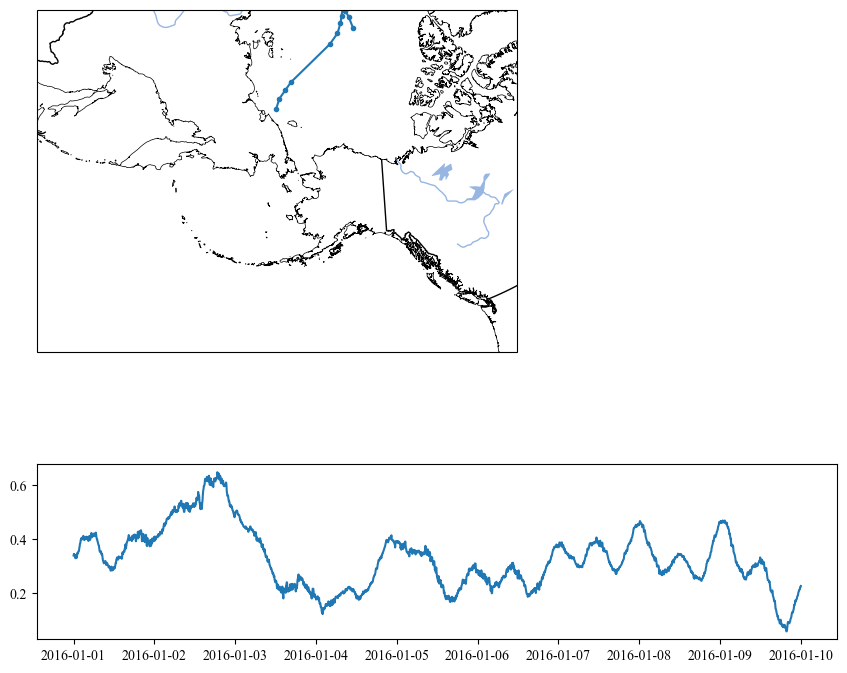

In [23]:

# map boundary ------------------------------------------------------------------------
lat1,lat2 = 45,90
lon1,lon2 = -220,-120

# -------------------------------------------------------------------------------------
plt.rcParams["font.family"] = "Times New Roman"
fig = plt.figure(figsize=(8,7))
proj = ccrs.NorthPolarStereo(central_longitude=-145)
ax1= plt.axes([0,0.28,0.6,0.75],projection=proj)
ax2 = plt.axes([0.,0.,1,0.25])
#ax[0].subplot_kw = dict(projection=proj)
cmap = mpl.cm.get_cmap('jet')
fig.tight_layout(pad=0.75)



ax1.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax1.coastlines(resolution='10m',linewidth=0.5)
ax1.add_feature(cart.feature.LAKES)
ax1.add_feature(cart.feature.RIVERS, linestyle="-")
ax1.add_feature(cart.feature.BORDERS.with_scale("50m"), linestyle="-")

start = 2016
end   = 2017
for t in storm['track']:
    noaa = None
    if start <= pd.to_datetime(t['time'][1]).year < end:
        xmin,xmax = -250,-120
        ymin,ymax = 0,90
        bbox1 = Polygon([[xmin,ymin],[xmax,ymin],[xmax,ymax],[xmin,ymax]])
        if ((bbox1.contains(Point(t['lon'][1],t['lat'][1])))&(bbox1.contains(Point(t['lon'][-1],t['lat'][-1])))):
            start2=str(pd.to_datetime(t['time'][1]).year)+str(pd.to_datetime(t['time'][1]).strftime('%m'))+'01'
            end2  =pd.to_datetime(t['time'][-1])
            noaa = json.loads(noaa_data(start2,end2,int(station),interval=interval,t_zone='LST',vdatum='MSL'))            
            if len(noaa)>1:
            
                ax1.plot(t['lon'],t['lat'],'.-',transform = ccrs.PlateCarree(),\
                        label=f"{pd.to_datetime(t['time'][1]).year} - {pd.to_datetime(t['time'][1]).month_name()}")

                ax2.plot(pd.to_datetime([noaa['data'][i]['t'] for i in range(len(noaa['data']))]),
                        [float(noaa['data'][i]['v']) for i in range(len(noaa['data']))],label='Station 1')
ax1.legend(loc='lower center', bbox_to_anchor=(1.55, 0.4),ncol=2,frameon=False,fontsize=12)
# subplot adjustment -----------------------------------------------------------
#plt.setp(ax[1].xaxis.get_label(), visible=True, text='Dates')
#plt.setp(ax[1].get_xticklabels(), visible=True, rotation=30, ha='right')
#ax2.set_xlim([pd.to_datetime('2004-01-01'),pd.to_datetime('2004-04-20')])
ax2.set_title('NOAA OBS Prudoe Bay')
ax2.set_ylim([-0.5,1])
ax2.xaxis.set_major_locator(plt.MaxNLocator(6)),ax2.yaxis.set_major_locator(plt.MaxNLocator(6))
ax2.grid(True)

#plt.savefig('/Users/tmiesse/work/FHRL/arctic/climate_data/era_interim/tracks/jan2004.png',dpi=450,bbox_inches = 'tight', pad_inches = 0.1)
plt.show(fig)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


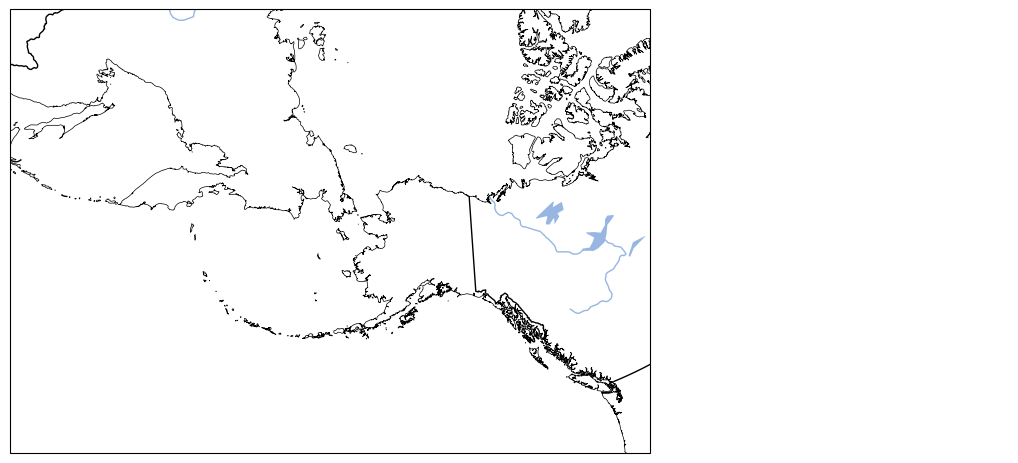

In [16]:

# map boundary ------------------------------------------------------------------------
lat1,lat2 = 45,85
lon1,lon2 = -220,-120

# -------------------------------------------------------------------------------------
plt.rcParams["font.family"] = "Times New Roman"
fig = plt.figure(figsize=(8,7))
proj = ccrs.NorthPolarStereo(central_longitude=-145)
ax1= plt.axes([0,0.,0.8,0.8],projection=proj)
#ax[0].subplot_kw = dict(projection=proj)
cmap = mpl.cm.get_cmap('jet')
fig.tight_layout(pad=0.75)



ax1.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax1.coastlines(resolution='10m',linewidth=0.5)
ax1.add_feature(cart.feature.LAKES)
ax1.add_feature(cart.feature.RIVERS, linestyle="-")
ax1.add_feature(cart.feature.BORDERS.with_scale("50m"), linestyle="-")

start = 2019
end   = 2020
for t in storm['track']:
    if start <= pd.to_datetime(t['time'][1]).year < end:
        xmin,xmax = -230,-120
        ymin,ymax = 30,75
        bbox1 = Polygon([[xmin,ymin],[xmax,ymin],[xmax,ymax],[xmin,ymax]])
        if ((bbox1.contains(Point(t['lon'][1],t['lat'][1])))&(bbox1.contains(Point(t['lon'][-1],t['lat'][-1])))):         
            ax1.plot(t['lon'],t['lat'],'.-',transform = ccrs.PlateCarree(),\
                    label=f"{pd.to_datetime(t['time'][1]).year} - {pd.to_datetime(t['time'][1]).month_name()}")


ax1.legend(loc='lower center', bbox_to_anchor=(1.55, 0.4),ncol=2,frameon=False,fontsize=12)
# subplot adjustment -----------------------------------------------------------
#plt.setp(ax[1].xaxis.get_label(), visible=True, text='Dates')
#plt.setp(ax[1].get_xticklabels(), visible=True, rotation=30, ha='right')
#ax2.set_xlim([pd.to_datetime('2004-01-01'),pd.to_datetime('2004-04-20')])

#plt.savefig('/Users/tmiesse/work/FHRL/arctic/climate_data/era_interim/tracks/jan2004.png',dpi=450,bbox_inches = 'tight', pad_inches = 0.1)
plt.show(fig)

In [29]:

mpts = []
years = []
months = []
name = []
start = 2016
end   = 2017
for t in storm['track']:    
    if start <= pd.to_datetime(t['time'][1]).year < end:
        xmin,xmax = -230,-120
        ymin,ymax = 20,75
        bbox1 = Polygon([[xmin,ymin],[xmax,ymin],[xmax,ymax],[xmin,ymax]])
        if ((bbox1.contains(Point(t['lon'][1],t['lat'][1])))&(bbox1.contains(Point(t['lon'][-1],t['lat'][-1])))):
            name.append(t['id'][1])
            years.append(t['time'][1].year)
            months.append(pd.to_datetime(t['time'][1]).month_name())
            pts = [Point(t['lon'][i],t['lat'][i]) for i in range(1,len(t['lat']))]
            mpts.append(LineString(pts))

            


In [30]:
shapefile = gpd.GeoDataFrame({'Cyclone':name,'Year':years,'Month':months, 'geometry':mpts},geometry='geometry',crs='epsg:4326')

In [31]:
shapefile.to_file('/Users/tmiesse/work/FHRL/arctic/model/climate_data/track_data/rasm_tracks/tracks.shp')

In [217]:
count

1706